# Attribute importance ranking for synthetic data with known change points
The process change points are known. Hence, no change point detection algorithm needs to be used.

In [1]:
import pm4py
import helper
from concept_drift import windows
from concept_drift import statistical_tests
import pandas as pd

In [2]:
# data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/ROI/ROI2.5k.xes'
data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/cb/cb10k.xes'

## Load an event log

In [3]:
# Display the data info
data_info = helper.get_data_information(data_file_path)
data_info

change_points = data_info['change_points']

In [4]:
# load the event log into pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply(data_file_path)

C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|█████████████████████████████████████████| 10000/10000 [00:06<00:00, 1666.06it/s]


In [13]:
# create windows of log and perform KS test in each window
window_size = 100
window_offset = window_size
slide_by = 10
log_windows = windows.get_log_windows(log, window_size, window_offset=window_offset, slide_by=slide_by, start=None, end=None, inclusion_criteria='traces_intersecting', type=None)

In [14]:
start_before_cp = 200 # look at 100 traces before each changepoint

In [15]:
# test each attribute for each log window
test_results = {}
for cp in change_points:
    test_results[cp] = {}
    
    # get all windows that have their start between (cp - start_before_cp) and cp
    relevant_windows_start = cp - start_before_cp
    if relevant_windows_start < 0: relevant_windows_start = 0
    relevant_windows_end = cp
    
    relevant_windows = {key: log_windows[key] for key in log_windows.keys() if (key >= relevant_windows_start) and (key <=relevant_windows_end)}
    
    for start, (window_a, window_b) in relevant_windows.items():
        test_results[cp][start] = {}
        
        attributes_window_a = helper.get_trace_attributes(window_a)
        attributes_window_b = helper.get_trace_attributes(window_b)
        
        # perform statistical test for each attribute
        # TODO handle the case that an attribute is not present in a given window
        for attribute_name, data_series_a in attributes_window_a.items():
            data_series_b = attributes_window_b[attribute_name]
            test_result = statistical_tests.test_chi_squared(data_series_a, data_series_b)
            test_results[cp][start][attribute_name] = test_result

C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\scipy\stats\stats.py:6707: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\L

In [16]:
results_df = pd.DataFrame().from_dict(test_results[list(test_results.keys())[0]], orient='index')

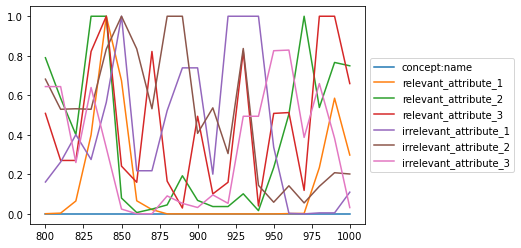

In [17]:
results_df.plot()
import matplotlib.pyplot as plt
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [82]:
def _get_consecutive_trues(df):
    """Gets the number of consecutive True values in each column of the dataframe.
    
    See https://stackoverflow.com/a/52718619.
    
    Args:
        df: Dataframe with only True and False values.
        
    Returns:
        Series with dataframe column names as index and consecutive True value counts as values.
    """
    # get the number of consecutive True values per Column
    b = df.cumsum()
    c = b.sub(b.mask(df).ffill().fillna(0)).astype(int)
    
    mask = df.any()
    consecutive_trues_array = np.where(mask, c.max(), -1)
    
    # put result into pandas Series
    consecutive_trues_series = pd.Series(consecutive_trues_array, index=df.columns)
    
    return consecutive_trues_series

def get_consecutive_under_threshold(df, threshold=0.05):
    """Counts the number of consecutive times that values in a column of a dataframe are smaller than a threshold.
    
    Args:
        df: Dataframe for which to count consecutive values under threshold.
        
    Returns:
        Series with dataframe column names as index and consecutive True value counts as values.
    """
    # convert the dataframe into a boolean data frame
    boolean_df = df < threshold
    
    # evaluate the number of consecutive True values per column
    consecutive_trues_series = _get_consecutive_trues(boolean_df)
    
    return consecutive_trues_series

In [84]:
import numpy as np
threshold = 0.05
# per change point, investigate which attribute was longest under a significance threshold of 0.05
for change_point, results in test_results.items():
    results_df = pd.DataFrame().from_dict(results, orient='index')
    
    consecutive_under_threshold = get_consecutive_under_threshold(results_df, threshold)
    
    display(f"Change point: {change_point}")
    display(consecutive_under_threshold)
    display("\n")

'Change point: 1000'

concept:name              21
relevant_attribute_1      11
relevant_attribute_2       3
relevant_attribute_3       1
irrelevant_attribute_1     4
irrelevant_attribute_2    -1
irrelevant_attribute_3     3
dtype: int32

'\n'

'Change point: 2000'

concept:name              21
relevant_attribute_1      -1
relevant_attribute_2      11
relevant_attribute_3       8
irrelevant_attribute_1     2
irrelevant_attribute_2     2
irrelevant_attribute_3     7
dtype: int32

'\n'

'Change point: 3000'

concept:name              21
relevant_attribute_1       1
relevant_attribute_2      -1
relevant_attribute_3      18
irrelevant_attribute_1     1
irrelevant_attribute_2     6
irrelevant_attribute_3     1
dtype: int32

'\n'

'Change point: 4000'

concept:name              21
relevant_attribute_1       5
relevant_attribute_2       9
relevant_attribute_3      11
irrelevant_attribute_1     2
irrelevant_attribute_2     2
irrelevant_attribute_3     1
dtype: int32

'\n'

'Change point: 5000'

concept:name              21
relevant_attribute_1       1
relevant_attribute_2       5
relevant_attribute_3       1
irrelevant_attribute_1     5
irrelevant_attribute_2     3
irrelevant_attribute_3     5
dtype: int32

'\n'

'Change point: 6000'

concept:name              21
relevant_attribute_1      -1
relevant_attribute_2      -1
relevant_attribute_3       4
irrelevant_attribute_1     4
irrelevant_attribute_2    -1
irrelevant_attribute_3     1
dtype: int32

'\n'

'Change point: 7000'

concept:name              21
relevant_attribute_1      -1
relevant_attribute_2       2
relevant_attribute_3       1
irrelevant_attribute_1     5
irrelevant_attribute_2     1
irrelevant_attribute_3     5
dtype: int32

'\n'

'Change point: 8000'

concept:name              21
relevant_attribute_1       3
relevant_attribute_2       4
relevant_attribute_3       6
irrelevant_attribute_1     1
irrelevant_attribute_2     1
irrelevant_attribute_3     1
dtype: int32

'\n'

'Change point: 9000'

concept:name              21
relevant_attribute_1       5
relevant_attribute_2       3
relevant_attribute_3      -1
irrelevant_attribute_1    -1
irrelevant_attribute_2    -1
irrelevant_attribute_3     2
dtype: int32

'\n'

In [11]:
data_info

{'file_path': 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb10k.xes',
 'file_name': 'cb10k',
 'drift_type': 'sudden',
 'dataset': 'maardji et al 2013',
 'is_synthetic': True,
 'has_generated_attributes': True,
 'size': 10000,
 'change_points': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
 'change_point_explanations': {'1000': [{'attribute_name': 'relevant_attribute_1',
    'drift_type': 'sudden',
    'drift_location': 1000}],
  '2000': [{'attribute_name': 'relevant_attribute_2',
    'drift_type': 'sudden',
    'drift_location': 2000}],
  '3000': [{'attribute_name': 'relevant_attribute_3',
    'drift_type': 'sudden',
    'drift_location': 3000}],
  '4000': [],
  '5000': [],
  '6000': [],
  '7000': [],
  '8000': [],
  '9000': []}}

In [12]:
# lets look at one change point
for attribute_name, test_results in reformated_results[250].items():
    start_times
    p_values
    for start, test_result in test_results.items():
        

SyntaxError: incomplete input (2796112929.py, line 6)

In [ ]:
log_windows.keys()